# Интеллектуальный анализ данных – весна 2024
# Домашнее задание 6: классификация текстов

Правила:



*   Домашнее задание оценивается в 10 баллов.
*   Можно использовать без доказательства любые результаты, встречавшиеся на лекциях или семинарах по курсу, если получение этих результатов не является вопросом задания.
*  Можно использовать любые свободные источники с *обязательным* указанием ссылки на них.
*  Плагиат не допускается. При обнаружении случаев списывания, 0 за работу выставляется всем участникам нарушения, даже если можно установить, кто у кого списал.
*  Старайтесь сделать код как можно более оптимальным. В частности, будет штрафоваться использование циклов в тех случаях, когда операцию можно совершить при помощи инструментов библиотек, о которых рассказывалось в курсе.

В этом домашнем задании вам предстоит построить классификатор текстов.

Будем предсказывать эмоциональную окраску твиттов о коронавирусе.



In [2]:
import numpy as np
import pandas as pd
from typing import List
import matplotlib.pyplot as plt
import seaborn as sns
from string import punctuation

In [3]:
df = pd.read_csv('https://raw.githubusercontent.com/hse-ds/iad-intro-ds/master/2024/homeworks/hw06_texts/tweets_coronavirus.csv', encoding='latin-1')
df.head(4)

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
1,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
2,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
3,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


Для каждого твитта указано:


*   UserName - имя пользователя, заменено на целое число для анонимности
*   ScreenName - отображающееся имя пользователя, заменено на целое число для анонимности
*   Location - местоположение
*   TweetAt - дата создания твитта
*   OriginalTweet - текст твитта
*   Sentiment - эмоциональная окраска твитта (целевая переменная)



## Задание 1 Подготовка (0.5 балла)

Целевая переменная находится в колонке `Sentiment`.  Преобразуйте ее таким образом, чтобы она стала бинарной: 1 - если у твитта положительная эмоциональная окраска и 0 - если отрицательная.

In [4]:
mask = df['Sentiment'].isin(['Positive', 'Extremely Positive'])

df.loc[mask, 'Sentiment'] = 1
df.loc[~mask, 'Sentiment'] = 0

Сбалансированы ли классы?

In [5]:
df['Sentiment'].value_counts()

Sentiment
1    18046
0    15398
Name: count, dtype: int64

**Ответ:** Классы сбалансированы (соотношение ~ 55/45)

Выведите на экран информацию о пропусках в данных. Если пропуски присутствуют заполните их строкой 'Unknown'.

In [6]:
print(f'Пропусков до замены: \n{df.isna().sum()}')
# 7049 пропусков по признаку Location

mask = df['Location'].isna()

df.loc[mask, 'Location'] = 'Unknown'

print(f'\nПропусков после замены: \n{df.isna().sum()}')


Пропусков до замены: 
UserName            0
ScreenName          0
Location         7049
TweetAt             0
OriginalTweet       0
Sentiment           0
dtype: int64

Пропусков после замены: 
UserName         0
ScreenName       0
Location         0
TweetAt          0
OriginalTweet    0
Sentiment        0
dtype: int64


Разделите данные на обучающие и тестовые в соотношении 7 : 3 и `random_state=0`

In [7]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size=0.3, random_state=0)

## Задание 2 Токенизация (3 балла)

Постройте словарь на основе обучающей выборки и посчитайте количество встреч каждого токена с использованием самой простой токенизации - деления текстов по пробельным символам и приведение токенов в нижний регистр

In [8]:
from collections import Counter

gigastring = ' '.join(train['OriginalTweet'].str.lower())

texts = [*train['OriginalTweet'].str.lower()]

words = gigastring.split()

tw_dict = dict(Counter(words))

tw_dict = {k: v for k, v in sorted(tw_dict.items(), key=lambda item: item[1], reverse=True)}

Какой размер словаря получился?

In [9]:
print(f'Размер словаря: {len(tw_dict)}')

Размер словаря: 79755


Выведите 10 самых популярных токенов с количеством встреч каждого из них. Объясните, почему именно эти токены в топе

In [10]:
dict(list(tw_dict.items())[:10])

{'the': 26815,
 'to': 23373,
 'and': 14684,
 'of': 13012,
 'a': 11737,
 'in': 11198,
 'for': 8566,
 '#coronavirus': 8223,
 'is': 7383,
 'are': 7050}

**Ответ:** В топе наиболее частотные слова английского языка + тематический тег (у нас же как раз тематическая подборка постов)

Удалите стоп-слова из словаря и выведите новый топ-10 токенов (и количество встреч) по популярности.  Что можно сказать  о нем?

In [11]:
import nltk
nltk.download("stopwords")

from nltk.corpus import stopwords

eng_stop_list = stopwords.words('english')

tw_dict_no_stop_words = {k: v for k, v in sorted(tw_dict.items(),
                                                  key=lambda item: item[1],
                                                  reverse=True) if k not in eng_stop_list}

dict(list(tw_dict_no_stop_words.items())[:10])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


{'#coronavirus': 8223,
 'prices': 3891,
 'food': 3820,
 'grocery': 3469,
 'supermarket': 3288,
 'people': 3175,
 'covid-19': 3173,
 'store': 3155,
 '#covid19': 2471,
 '&amp;': 2314}

**Ответ:**  Топ-лист стал более содержательным и информативным. По предыдущей версии топа (если убрать из него хэштег) невозможно было определить основную тему сообщений, а по текущей -- вполне.

Также выведите 20 самых непопулярных слов (если самых непопулярных слов больше выведите любые 20 из них) Почему эти токены непопулярны, требуется ли как-то дополнительно работать с ними?

In [12]:
print(f'Всего токенов с самым низким значением частоты: {sum([elem == 1 for elem in tw_dict_no_stop_words.values()])}')

print('\n20 последних токенов с самым низким значением частоты:\n')
dict(list(tw_dict_no_stop_words.items())[-20:])

Всего токенов с самым низким значением частоты: 56476

20 последних токенов с самым низким значением частоты:



{'skellig': 1,
 'coast!': 1,
 'closer!)': 1,
 '@skelligsix18': 1,
 '#skelligcoast2kms': 1,
 '#southkerry': 1,
 'https://t.co/zjcl195vqs': 1,
 '@srinivasiyc': 1,
 'https://t.co/iaek4fwsgz': 1,
 'premiership': 1,
 'non-playing': 1,
 'subsidise': 1,
 'playersã\x82â\x92': 1,
 'renewing': 1,
 'wage!': 1,
 'flew': 1,
 'nothing...': 1,
 '@torontopearson': 1,
 '@680news': 1,
 'https://t.co/7j2y3rsld9': 1}

**Ответ:**
- Часть токенов не очищена от знаков препинания и хэштегов -- если почистить тексты от знаков препинания, эти токены сольются с остальными токенами того же типа и дадут дополнительную информацию по частоте (например, токен *wage!* явно покажет более высокую частотность, если убрать из него !)
- Часть токенов представляет собой ссылки и никнеймы -- вероятно, они неинформативны или малоинформативны (впрочем, зависит от задачи)
- Часть токенов представляет собой редкие слова -- есть ощущение, что их полезный вклад в обучение модели будет минимальным, соответственно, ими можно попробовать пренебречь (но это не точно)



Теперь воспользуемся токенайзером получше - TweetTokenizer из библиотеки nltk. Примените его и посмотрите на топ-10 популярных слов. Чем он отличается от топа, который получался раньше? Почему?

In [13]:
from nltk.tokenize import TweetTokenizer

tknzr = TweetTokenizer()
tw_tokens = tknzr.tokenize(gigastring)

tw_dict_2 = dict(Counter(tw_tokens))

new_tw_dict = {k: v for k, v in sorted(tw_dict_2.items(),
                                                  key=lambda item: item[1],
                                                  reverse=True)}

dict(list(new_tw_dict.items())[:10])

{'the': 26993,
 '.': 24108,
 'to': 23478,
 ',': 17571,
 'and': 14825,
 'of': 13044,
 'a': 11891,
 'in': 11348,
 '?': 9524,
 '#coronavirus': 8808}

**Ответ:** Частично похож на топ, который получался раньше, но теперь ещё есть знаки пунктуации, которые при применении split ранее в основном прилипали к слову слева, т.к. разбиение происходило по пробелу

Удалите из словаря стоп-слова и пунктуацию, посмотрите на новый топ-10 слов с количеством встреч, есть ли теперь в нем что-то не похожее на слова?

In [14]:
from string import punctuation

new_tw_dict = {k: v for k, v in sorted(tw_dict_2.items(),
                                                  key=lambda item: item[1],
                                                  reverse=True) if (k not in eng_stop_list) \
                                                  and (k not in punctuation)}

dict(list(new_tw_dict.items())[:10])

{'#coronavirus': 8808,
 'â': 7415,
 '\x82': 7311,
 '19': 7167,
 'covid': 6253,
 'prices': 4601,
 '\x92': 4372,
 'food': 4367,
 'store': 3877,
 'supermarket': 3805}

**Ответ:** Да, остаются коды unicode (если я правильно понял, что такое \x82) и числа

Удалите из словаря токены из одного символа, с позицией в таблице Unicode 128 и более (`ord(x) >= 128`)

Выведите топ-10 самых популярных и топ-20 непопулярных слов. Чем полученные топы отличаются от итоговых топов, полученных при использовании токенизации по пробелам? Что теперь лучше, а что хуже?

In [15]:
clean_tw_dict = {k: v for k, v in sorted(new_tw_dict.items(),
                                                  key=lambda item: item[1],
                                                  reverse=True) \
                 if (len(k) == 1 and ord(k) < 128) or (len(k) > 1)}

print('Топ-10 самых популярных токенов:')
dict(list(clean_tw_dict.items())[:10])

Топ-10 самых популярных токенов:


{'#coronavirus': 8808,
 '19': 7167,
 'covid': 6253,
 'prices': 4601,
 'food': 4367,
 'store': 3877,
 'supermarket': 3805,
 'grocery': 3523,
 'people': 3463,
 '#covid19': 2589}

In [16]:
print('Топ-20 самых непопулярных токенов')
dict(list(clean_tw_dict.items())[-20:])

Топ-20 самых непопулярных токенов


{'https://t.co/lw1r0rm7xs': 1,
 'https://t.co/5cbliqzx7l': 1,
 'now.when': 1,
 'milion': 1,
 'skellig': 1,
 '@skelligsix18': 1,
 '#skelligcoast2kms': 1,
 '#southkerry': 1,
 'https://t.co/zjcl195vqs': 1,
 '@srinivasiyc': 1,
 'https://t.co/iaek4fwsgz': 1,
 'premiership': 1,
 'non-playing': 1,
 'subsidise': 1,
 'playersã': 1,
 'renewing': 1,
 'flew': 1,
 '@torontopearson': 1,
 '@680news': 1,
 'https://t.co/7j2y3rsld9': 1}

**Ответ:**
- Отличие от топов при токенизации по пробелам: в текущие топы попали хэштеги и никнеймы.
- Что лучше: wage! и прочие перестали быть уникальными токенами,
- Что хуже: многосоставные слова (с дефисами посередине, с числами) поделились на части (covid-19 -> covid, 19)

Выведите топ-10 популярных хештегов с количеством встреч. Что можно сказать о них?

In [17]:
hashtags = {k: v for k, v in sorted(new_tw_dict.items(), key=lambda item: item[1],
                                                  reverse=True) \
                          if k[0] == '#'}

print('Топ-10 самых популярных хэштегов:')
dict(list(hashtags.items())[:10])

Топ-10 самых популярных хэштегов:


{'#coronavirus': 8808,
 '#covid19': 2589,
 '#covid_19': 1734,
 '#covid2019': 946,
 '#toiletpaper': 744,
 '#covid': 641,
 '#socialdistancing': 465,
 '#coronacrisis': 448,
 '#pandemic': 257,
 '#coronaviruspandemic': 249}

**Ответ:** Хэштеги содержателные и порождают флэшбеки у любого человека, пережившего 2020 год.

То же самое проделайте для ссылок на сайт https://t.co Сравнима ли популярность ссылок с популярностью хештегов? Будет ли информация о ссылке на конкретную страницу полезна?

In [18]:
links = {k: v for k, v in sorted(new_tw_dict.items(), key=lambda item: item[1],
                                                  reverse=True) \
                          if 'https://t.co' in k}

print('Топ-10 популярных ссылок:')
dict(list(links.items())[:10])

Топ-10 популярных ссылок:


{'https://t.co/oxa7swtond': 5,
 'https://t.co/gp3eusapl8': 4,
 'https://t.co/deftrui1pfã\x82â': 3,
 'https://t.co/wrlhyzizaa': 3,
 'https://t.co/kuwipf1kqw': 3,
 'https://t.co/zjnrx6dkkn': 3,
 'https://t.co/3gbbdpdjat': 3,
 'https://t.co/e2znxajpre': 3,
 'https://t.co/catkegayoy': 3,
 'https://t.co/g63rp042ho': 3}

**Ответ:** Разница частот популярных хэштегов и ссылок -- тысячи vs единицы. Популярность ссылок не сравнима. Информация о ссылке на конкретную страницу вряд ли будет полезна при обучении модели

Используем опыт предыдущих экспериментов и напишем собственный токенайзер, улучшив TweetTokenizer. Функция tokenize должна:



*   Привести текст в нижний регистр
*   Применить TweetTokenizer для изначального выделения токенов
*   Удалить стоп-слова, пунктуацию, токены из одного символа, с позицией в таблице Unicode 128 и более и ссылки на t.co



In [19]:
def custom_tokenizer(text: str) -> list[str]:

  def is_ok(token):
    if token in eng_stop_list: # внешние зависимости(((
      return False
    if token in punctuation:   # и ещё внешние зависимости
      return False
    if (len(token) == 1) and (ord(token) >= 128):
      return False
    if 'https://t.co' in token:
      return False
    return True

  raw_tokens = TweetTokenizer().tokenize(text.lower())

  tokens = [token for token in raw_tokens if is_ok(token)]

  return tokens


In [20]:
custom_tokenizer('This is sample text!!!! @Sample_text I, \x92\x92 https://t.co/sample  #sampletext')

['sample', 'text', '@sample_text', '#sampletext']

## Задание 3 Векторизация текстов (2 балла)

Обучите CountVectorizer с использованием custom_tokenizer в качестве токенайзера. Как размер полученного словаря соотносится с размером изначального словаря из начала задания 2?

In [21]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(tokenizer=custom_tokenizer)

X = cv.fit_transform(texts)

print(len(cv.vocabulary_))

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


45306


**Ответ:** Полученный словарь примерно в два раза меньше исходного (вероятно, по какому-то принципу отсеяны наименее значимые признаки)

Посмотрим на какой-нибудь конкретный твитт:

In [22]:
ind = 9023
train.iloc[ind]['OriginalTweet'], train.iloc[ind]['Sentiment']

('Nice one @SkyNews lets not panic but show ppl in france queueing for food!!! #CoronavirusOutbreak #COVID2019 brainless!! Ffs',
 0)

Автор твитта не доволен ситуацией с едой во Франции и текст имеет резко негативную окраску.

Примените обученный CountVectorizer для векторизации данного текста, и попытайтесь определить самый важный токен и самый неважный токен (токен, компонента которого в векторе максимальна/минимальна, без учета 0). Хорошо ли они определились, почему?

In [23]:
values = cv.transform([train.iloc[ind]['OriginalTweet']]).toarray()
features = cv.get_feature_names_out()

test_tweet = pd.DataFrame(data=values, columns=features).T

In [24]:
test_tweet.loc[test_tweet[0] > 0, :]

,0
#coronavirusoutbreak,1
#covid2019,1
@skynews,1
brainless,1
ffs,1
food,1
france,1
lets,1
nice,1
one,1


**Ответ:** С помощью countvectorizer просто определились те токены, которые используются в анализируемом тексте; учитывая, что все они используются по разу, т.е. у каждого значение не выше единицы, их компоненты в векторе равны. Если посмотреть на текст по-человечески, кажется, что наибольший вклад в тональность вносят слова brainless и panic (nice one тоже неплохо, но, наверное, eval_irony() в нашей модели не предусмотрено)

Теперь примените TfidfVectorizer и  определите самый важный/неважный токены. Хорошо ли определились, почему?

In [25]:
from sklearn.feature_extraction.text import TfidfVectorizer

cv_tfid = TfidfVectorizer(tokenizer=custom_tokenizer)

X_tfid = cv_tfid.fit_transform(texts)

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [26]:
values = cv_tfid.transform([train.iloc[ind]['OriginalTweet']]).toarray()
features = cv_tfid.get_feature_names_out()

test_tweet = pd.DataFrame(data=values, columns=features).T

test_tweet.loc[test_tweet[0] > 0, :].sort_values(0, ascending=False)

,0
brainless,0.386764
queueing,0.354346
ffs,0.324474
france,0.320473
@skynews,0.310426
lets,0.301211
ppl,0.255006
nice,0.254273
show,0.244065
#coronavirusoutbreak,0.225843


**Ответ:** Самый важный токен совпадает с интуицией. Насчёт неважности food и panic неясно

Найдите какой-нибудь положительно окрашенный твитт, где TfidfVectorizer хорошо (полезно для определения окраски) выделяет важный токен, поясните пример.

*Подсказка:* явно положительные твитты можно искать при помощи положительных слов (good, great, amazing и т. д.)

In [27]:
good_ones = train[train['OriginalTweet'].apply(lambda x: 'beautiful' in x) & (train['Sentiment'] == 1)]

good_ones = good_ones['OriginalTweet']

In [28]:
values = cv_tfid.transform(good_ones).toarray()

mask = np.sum((values != 0), axis=0) != 0

features = cv_tfid.get_feature_names_out()

good_tweets = pd.DataFrame(data=values, columns=features).T

good_tweets = good_tweets.loc[mask, :]

good_tweets.max().sort_values(ascending=False)
# берём одного из лидеров из good_ones

ind = 11

test_tweet = pd.DataFrame(good_tweets.loc[:, ind])

test_tweet.loc[test_tweet[ind] > 0, :].sort_values(ind, ascending=False)


,11
memories,0.481457
#memories,0.273814
days,0.265320
#trumpplague,0.263106
happiness,0.255508
#trumppandemic,0.244800
memory,0.234091
dream,0.210486
smile,0.207110
beautiful,0.206074


**Ответ:** Видим, что в твите №11 из подборки хорошо выделен целый ряд позитивных слов: dream, smile, beautiful, и максимальным весом обладает достаточно нейтральное слово -- memory (memories), которое, тем не менее, оказавшись в одном ряду с однозначно положительными словами dream, smile и beautiful, усиливает их положительное значение (собирая их в тему "ностальгия", "приятные воспоминания")

## Задание 4 Обучение первых моделей (1 балл)

Примените оба векторайзера для получения матриц с признаками текстов.  Выделите целевую переменную.

In [29]:
# cv и cv_tfid

X_train_cv = cv.transform(train['OriginalTweet'])
X_train_tfid = cv_tfid.transform(train['OriginalTweet'])
y_train = train['Sentiment'].astype('int')

X_test_cv = cv.transform(test['OriginalTweet'])
X_test_tfid = cv_tfid.transform(test['OriginalTweet'])
y_test = test['Sentiment'].astype('int')

Обучите логистическую регрессию на векторах из обоих векторайзеров. Посчитайте долю правильных ответов на обучающих и тестовых данных. Какой векторайзер показал лучший результат? Что можно сказать о моделях?

In [30]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

log_reg = LogisticRegression()

log_reg.fit(X_train_cv, y_train)

print(f'\nCount_vec Log_reg accuracy: {accuracy_score(y_test, log_reg.predict(X_test_cv))}')

log_reg.fit(X_train_tfid, y_train)
print(f'\nTFID_vec Log_reg accuracy: {accuracy_score(y_test, log_reg.predict(X_test_tfid))}')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



Count_vec Log_reg accuracy: 0.8675503288818018

TFID_vec Log_reg accuracy: 0.8533984452860275


**Ответ:** Модели (одна модель, разные способы векторизации) показывают похожие результаты. Count_vectorizer показал результаты чуть лучше (~ на 1.5%)

## Задание 5 Стемминг (0.5 балла)

Для уменьшения словаря можно использовать стемминг.

Модифицируйте написанный токенайзер, добавив в него стемминг с использованием SnowballStemmer. Обучите Count- и Tfidf- векторайзеры. Как изменился размер словаря?

In [31]:
from nltk.stem.snowball import SnowballStemmer

stemmer = SnowballStemmer('english')

def custom_stem_tokenizer(text):

  def is_ok(token):
    if token in eng_stop_list: # внешние зависимости(((
      return False
    if token in punctuation:   # и ещё внешние зависимости
      return False
    if (len(token) == 1) and (ord(token) >= 128):
      return False
    if 'https://t.co' in token:
      return False
    return True

  raw_tokens = TweetTokenizer().tokenize(text.lower())

  tokens = [stemmer.stem(token) for token in raw_tokens if is_ok(token)]

  return tokens


In [32]:
custom_stem_tokenizer('This is sample text!!!! @Sample_text I, \x92\x92 https://t.co/sample  #sampletext adding more words to check stemming')

['sampl', 'text', '@sample_text', '#sampletext', 'ad', 'word', 'check', 'stem']

In [33]:
cv = CountVectorizer(tokenizer=custom_stem_tokenizer)
cv_tfid = TfidfVectorizer(tokenizer=custom_stem_tokenizer)

cv.fit_transform(texts)
cv_tfid.fit_transform(texts)

print(f'Длина словаря count_vectorizer: {len(cv.vocabulary_)}')

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Длина словаря count_vectorizer: 36650


**Ответ** Длина словаря ещё уменьшилась в сравнении с кастомным токенизатором (что логично -- условно говоря, однокоренные токены слились в один тип)

Обучите логистическую регрессию с использованием обоих векторайзеров. Изменилось ли качество? Есть ли смысл применять стемминг?

In [34]:
X_train_cv = cv.transform(train['OriginalTweet'])
X_train_tfid = cv_tfid.transform(train['OriginalTweet'])

X_test_cv = cv.transform(test['OriginalTweet'])
X_test_tfid = cv_tfid.transform(test['OriginalTweet'])

log_reg = LogisticRegression()

log_reg.fit(X_train_cv, y_train)

print(f'\nCount_vec Log_reg accuracy: {accuracy_score(y_test, log_reg.predict(X_test_cv))}')

log_reg.fit(X_train_tfid, y_train)
print(f'\nTFID_vec Log_reg accuracy: {accuracy_score(y_test, log_reg.predict(X_test_tfid))}')

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



Count_vec Log_reg accuracy: 0.8672513454255532

TFID_vec Log_reg accuracy: 0.8560892963922663


**Ответ:** Стемминг дал незначительный прирост результата на обучающей выборке и снижение результата на тестовой. Кажется, использование стемминга нецелесообразно

## Задание  6 Работа с частотами (1.5 балла)

Еще один способ уменьшить количество признаков - это использовать параметры min_df и max_df при построении векторайзера  эти параметры помогают ограничить требуемую частоту встречаемости токена в документах.

По умолчанию берутся все токены, которые встретились хотя бы один раз.



Подберите max_df такой, что размер словаря будет 36651 (на 1 меньше, чем было). Почему параметр получился такой большой/маленький?

In [35]:
stemmed_words = custom_stem_tokenizer(gigastring)

In [36]:
len(set(stemmed_words))

vocab = dict(Counter(stemmed_words))


vocab_sorted = sorted(vocab.items(), key=lambda item: item[1], reverse=True)

In [37]:
vocab_sorted[3699:3700]

[('#retailnew', 11)]

In [38]:
cv_df = CountVectorizer(tokenizer=custom_stem_tokenizer,
                        max_df=7000
                        ).fit(texts)
print(len(cv_df.vocabulary_))

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


36649


**Ответ:** Для того, чтобы отсечь сверху 1 значение, нужно взять частоту наиболее популярного токена - 1 (см. код выше; т.к. хэштеги, по всей видимости, каунтвекторайзером отсекаются, берём 7000, чтобы отсечь число 19). Единственное, что исходный словарь был длиной 36650, поэтому целевое значение -- 36649

Подберите min_df (используйте дефолтное значение max_df) в CountVectorizer таким образом, чтобы размер словаря был 3700 токенов (при использовании токенайзера со стеммингом), а качество осталось таким же, как и было. Что можно сказать о результатах?

In [39]:
cv_df = CountVectorizer(tokenizer=custom_stem_tokenizer,
                        min_df=11
                        ).fit(texts)
print(len(cv_df.vocabulary_))

3700


In [40]:
X_train_cv = cv_df.transform(train['OriginalTweet']).toarray()

X_test_cv = cv_df.transform(test['OriginalTweet']).toarray()

log_reg = LogisticRegression()

log_reg.fit(X_train_cv, y_train)

print(f'\nCount_vec Log_reg accuracy train: {accuracy_score(y_train, log_reg.predict(X_train_cv))}')
print(f'\nCount_vec Log_reg accuracy test: {accuracy_score(y_test, log_reg.predict(X_test_cv))}')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



Count_vec Log_reg accuracy train: 0.9284493806065783

Count_vec Log_reg accuracy test: 0.8677496511859677


**Ответ:** # Не понял вопрос про качество

В предыдущих заданиях признаки не скалировались. Отскалируйте данные (при словаре размера 3.7 тысяч, векторизованные CountVectorizer), обучите логистическую регрессию, посмотрите качество и выведите `berplot` содержащий по 10 токенов, с наибольшим по модулю положительными/отрицательными весами. Что можно сказать об этих токенах?

In [41]:
from sklearn.preprocessing import StandardScaler

X_train_cv = cv_df.transform(train['OriginalTweet']).toarray()
sc = StandardScaler()

X_train_cv = sc.fit_transform(X_train_cv)

X_test_cv = cv_df.transform(test['OriginalTweet']).toarray()
X_test_cv = sc.transform(X_test_cv)

In [42]:
log_reg = LogisticRegression()

log_reg.fit(X_train_cv, y_train)

print(f'\nCount_vec Log_reg accuracy train: {accuracy_score(y_train, log_reg.predict(X_train_cv))}')
print(f'\nCount_vec Log_reg accuracy test: {accuracy_score(y_test, log_reg.predict(X_test_cv))}')



Count_vec Log_reg accuracy train: 0.9416915847928236

Count_vec Log_reg accuracy test: 0.8446282639027307


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [43]:
coeffs = log_reg.coef_


sorted_index_array = np.argsort(coeffs)
coeffs[0][sorted_index_array]


array([[-1.75240867, -1.3119122 , -1.06721195, ...,  1.07894184,
         1.10823457,  1.23170974]])

In [44]:
cv_df.get_feature_names_out()[sorted_index_array]

array([['crisi', 'panic', 'scam', ..., 'help', 'free', 'hand']],
      dtype=object)

**Ответ:** По результатам: возможно, произошло переобучение. По токенам с максимальным весом: токены в токенайзере почему-то расположены в алфавитном порядке, а веса при этом упорядочены. Не понимаю

## Задание 7 Другие признаки (1.5 балла)

Мы были сконцентрированы на работе с текстами твиттов и не использовали другие признаки - имена пользователя, дату и местоположение

Изучите признаки UserName и ScreenName. полезны ли они? Если полезны, то закодируйте их, добавьте к матрице с отскалированными признаками, обучите логистическую регрессию, замерьте качество.

In [45]:
unique_usernames = len(df['UserName'].value_counts())
print(f'Уникальных значений в UserName: {unique_usernames}, всего значений {df.shape[0]}')

unique_screennames = len(df['ScreenName'].value_counts())
print(f'Уникальных значений в ScreenName: {unique_screennames}, всего значений {df.shape[0]}')


Уникальных значений в UserName: 33444, всего значений 33444
Уникальных значений в ScreenName: 33444, всего значений 33444


**Ответ:** Все значения обоих признаков уникальны, значит пользы в них не много -- легко переобучиться, да и неочевидно, какие закономерности можно было бы вывести в таком случае

Изучите признак TweetAt в обучающей выборке: преобразуйте его к типу datetime и нарисуйте его гистограмму с разделением по цвету на оспнове целевой переменной. Полезен ли он? Если полезен, то закодируйте его, добавьте к матрице с отскалированными признаками, обучите логистическую регрессию, замерьте качество.

(array([18338., 18342., 18346., 18350., 18353., 18357., 18361., 18365.]),
 [Text(18338.0, 0, '2020-03-17'),
  Text(18342.0, 0, '2020-03-21'),
  Text(18346.0, 0, '2020-03-25'),
  Text(18350.0, 0, '2020-03-29'),
  Text(18353.0, 0, '2020-04-01'),
  Text(18357.0, 0, '2020-04-05'),
  Text(18361.0, 0, '2020-04-09'),
  Text(18365.0, 0, '2020-04-13')])

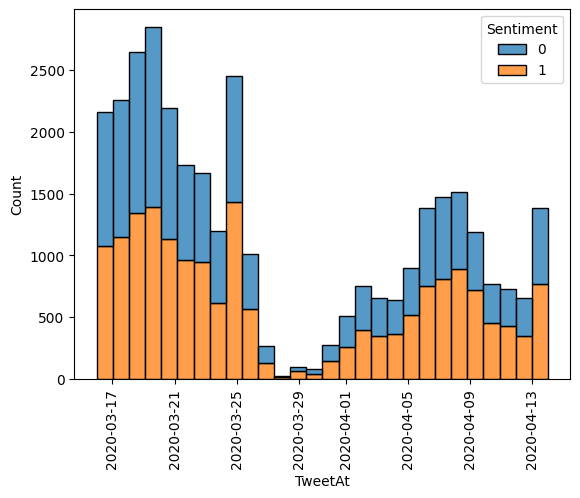

In [46]:
dates = pd.concat([pd.to_datetime(df['TweetAt'], dayfirst=True), df['Sentiment']], axis=1)

sns.histplot(x=dates['TweetAt'], hue=dates['Sentiment'], multiple='stack')
plt.xticks(rotation=90)

Кажется, что этот признак тоже не несёт особой пользы, но на всякий случай попробуем добавить его в данные и посмотрим на результат

In [47]:
X_train_cv = cv_df.transform(train['OriginalTweet']).toarray()
X_test_cv = cv_df.transform(test['OriginalTweet']).toarray()

In [48]:
X_train_cv_w_dates = pd.concat([pd.DataFrame(X_train_cv), pd.DataFrame(train['TweetAt'])], axis=1)
X_test_cv_w_dates = pd.concat([pd.DataFrame(X_test_cv), test['TweetAt']])

In [49]:
vec = pd.DataFrame(X_train_cv)

date = pd.DataFrame(train['TweetAt']).reset_index()
date = np.array(date)
date = pd.DataFrame(np.delete(date, 0, 1))

train_dates = pd.concat([vec, date], axis=1)

vec = pd.DataFrame(X_test_cv)

date = pd.DataFrame(test['TweetAt']).reset_index()
date = np.array(date)
date = pd.DataFrame(np.delete(date, 0, 1))

test_dates = pd.concat([vec, date], axis=1)


In [50]:
train_dates = pd.get_dummies(train_dates, drop_first=True)
test_dates = pd.get_dummies(test_dates, drop_first=True)

train_dates.columns = train_dates.columns.astype(str)
test_dates.columns = test_dates.columns.astype(str)


log_reg = LogisticRegression()

log_reg.fit(train_dates, y_train)

print(f'\nCount_vec Log_reg accuracy train: {accuracy_score(y_train, log_reg.predict(train_dates))}')
print(f'\nCount_vec Log_reg accuracy test: {accuracy_score(y_test, log_reg.predict(test_dates))}')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



Count_vec Log_reg accuracy train: 0.9296454506621102

Count_vec Log_reg accuracy test: 0.8671516842734702


**Ответ:** ЧТД -- на тесте улучшений от добавления даты твита нет



Поработайте с признаком Location в обучающей выборке. Сколько уникальных значений?

In [51]:
unique_locations = len(train['Location'].value_counts())
print(f'Уникальных значений Location в обучающей выборке: {unique_locations}, всего значений {train.shape[0]}')

Уникальных значений Location в обучающей выборке: 7949, всего значений 23410


Постройте гистограмму топ-10 по популярности местоположений (исключая Unknown)

<Axes: xlabel='count', ylabel='Location'>

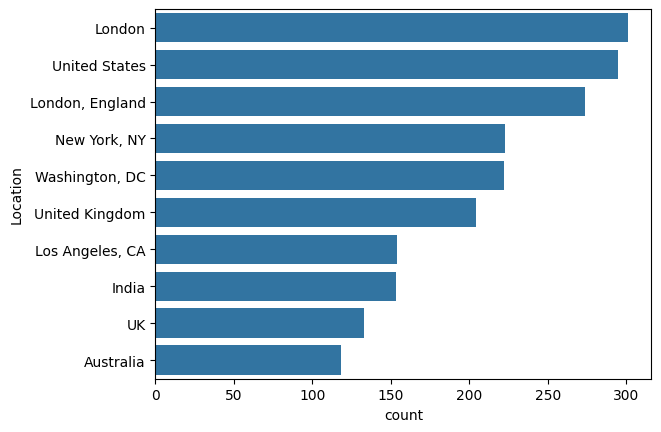

In [52]:
top_locs = pd.DataFrame(train['Location'].value_counts()[1:11])

sns.barplot(top_locs, y='Location', x="count")

Видно, что многие местоположения включают в себя более точное название места, чем другие (Например, у некоторых стоит London, UK; а у некоторых просто UK или United Kingdom).

Создайте новый признак WiderLocation, который содержит самое широкое местоположение (например, из London, UK должно получиться UK). Сколько уникальных категорий теперь? Постройте аналогичную гистограмму.

In [53]:
import re

def get_wider_location(location):
  if location[-1] == ',':
    location = location[:-1]
  if ',' in location:
    new_loc = re.search(r',[ ]?[^,]+$', location)
    if new_loc.group()[2:] in ('England', 'United Kingdom', 'London'):
      return 'UK'
    if new_loc.group()[2:] in ('United States', 'New York', 'NY', 'CA', 'TX',
                               'DC', 'FL', 'IL', 'MA', 'PA', 'GA', 'Texas',
                               'NC', 'MI', 'NJ', 'WA', 'VA', 'OH', 'CO', 'AZ',
                               'TN', 'MO', 'MD', 'IN', 'Ohio', 'New York City',
                               'SC', 'Florida'):
      return 'USA'
    if new_loc.group()[2:] == 'New York':
      return 'NY'
    return new_loc.group()[2:]
  else:
    return location


def rename_uk_us(loc):
  if loc in ('United Kingdom', 'London', 'Scotland'):
    return 'UK'
  if loc in ('United States', 'New York', 'New York City'):
    return 'USA'
  if loc == 'Ontario':
    return 'Canada'
  if loc == 'Unknown':
    return None
  return loc

train['WiderLocation'] = train['Location'].map(get_wider_location)

train['WiderLocation'] = train['WiderLocation'].map(rename_uk_us)

# заодно делаем для тестовой то же

test['WiderLocation'] = test['Location'].map(get_wider_location)

test['WiderLocation'] = test['WiderLocation'].map(rename_uk_us)


Уникальных значений WiderLocation в обучающей выборке: 4866, всего значений 23410


<Axes: xlabel='count', ylabel='WiderLocation'>

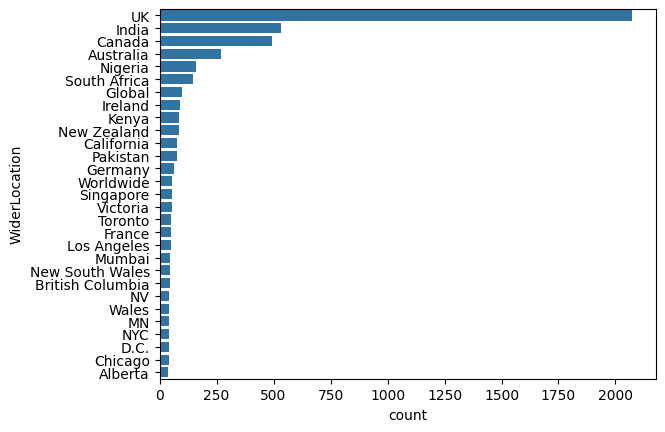

In [54]:
unique_locations = len(train['WiderLocation'].value_counts())
print(f'Уникальных значений WiderLocation в обучающей выборке: {unique_locations}, всего значений {train.shape[0]}')

top_locs = pd.DataFrame(train['WiderLocation'].value_counts()[1:30])

sns.barplot(top_locs, y='WiderLocation', x="count")

In [55]:
freq_cats = list(train['WiderLocation'].value_counts()[train['WiderLocation'].value_counts() > 1].index)

Закодируйте признак WiderLocation с помощью OHE таким образом, чтобы создались только столбцы для местоположений, которые встречаются более одного раза. Сколько таких значений?


In [56]:
wider_locs = pd.get_dummies(train['WiderLocation'])
wider_locs_test = pd.get_dummies(test['WiderLocation'])

min_freq_mask = wider_locs.sum() > 1

min_freq_wider_locs = wider_locs.loc[:, min_freq_mask]

print(f'Значений WiderLocation, встречающихся больше одного раза {min_freq_wider_locs.shape[1]} штук')

# заодно делаем то же для тестовой выборки

min_freq_mask_test = wider_locs_test.columns.isin(min_freq_wider_locs.columns)

min_freq_wider_locs_test = wider_locs_test.loc[:, min_freq_mask_test]


Значений WiderLocation, встречающихся больше одного раза 1005 штук


Добавьте этот признак к матрице отскалированных текстовых признаков, обучите логистическую регрессию, замерьте качество. Как оно изменилось? Оказался ли признак полезным?


*Подсказка:* используйте параметр `categories` в энкодере.

In [57]:
# доделываем обучающий набор объектов
X_train_wider_locs = pd.concat([pd.DataFrame(X_train_cv, index=min_freq_wider_locs.index), min_freq_wider_locs], axis=1)

# делаем ту же штуку для тестовой (хотя непонятно, что делать с недостающими признаками...)
X_test_wider_locs = pd.concat([pd.DataFrame(X_test_cv, index=min_freq_wider_locs_test.index), min_freq_wider_locs_test], axis=1)

In [58]:
log_reg = LogisticRegression()

X_train_wider_locs.columns = X_train_wider_locs.columns.astype(str)
# X_test_wider_locs.columns = X_test_wider_locs.columns.astype(str)

log_reg.fit(X_train_wider_locs, y_train)

print(f'\nCount_vec Log_reg accuracy train: {accuracy_score(y_train, log_reg.predict(X_train_wider_locs))}')
# print(f'\nCount_vec Log_reg accuracy test: {accuracy_score(y_test, log_reg.predict(X_test_wider_locs))}')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



Count_vec Log_reg accuracy train: 0.9319094404100812


In [115]:
spisok = list(X_test_wider_locs.columns)

mask = list(~X_train_wider_locs.columns.isin(spisok))

absent_cols = X_train_wider_locs.columns[mask]

absent_cols

for col in absent_cols:
  X_test_wider_locs[col] = 0

X_test_wider_locs.columns = X_test_wider_locs.columns.astype(str)
columns = list(X_train_wider_locs.columns)

X_test_wider_locs = X_test_wider_locs[columns]

print(f'\nCount_vec Log_reg accuracy test: {accuracy_score(y_test, log_reg.predict(X_test_wider_locs))}')



Count_vec Log_reg accuracy test: 0.8667530396651385


**Ответ:** Качество на обучающей выборке не изменилось, признак не оказался полезным

## Задание 8 Хорошее качество (Бонус 1 балл)

Добейтесь accuracy=0.9 на тестовой выборке (можно сменить токенайзер, векторайзер, модель и т.д.)

In [ ]:
# -- YOUR CODE HERE --